In [ ]:
import PIL
from torchvision import transforms
import os
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch_lightning --quiet
import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

pytorch_lightning.utilities.seed.seed_everything(seed=123)

     |████████████████████████████████| 819kB 37.4MB/s 
     |████████████████████████████████| 645kB 49.7MB/s 
     |████████████████████████████████| 10.6MB 51.6MB/s 
     |████████████████████████████████| 122kB 61.4MB/s 
     |████████████████████████████████| 235kB 51.4MB/s 
     |████████████████████████████████| 829kB 37.9MB/s 
     |████████████████████████████████| 1.3MB 40.0MB/s 
     |████████████████████████████████| 143kB 59.4MB/s 
     |████████████████████████████████| 296kB 57.3MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


Global seed set to 123


123

# Pre-processing

## Dataset Class

*   The following Dataset class loads the data into memory;
*   As the images may be resized, a masked_fill is used for the segmentation map in order to ensure only 0 or 1 values.



In [ ]:
class TrainingDataset(torch.utils.data.Dataset):

    def __init__(self, files, transform, common_transform):    
        img = []
        img_y = []
        path = '/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/dataset/'
        for file in files:
            img_carregada = PIL.Image.open(path + file + '.png')
            img_grayscale = PIL.ImageOps.grayscale(img_carregada)
            img.append(img_grayscale)
            img_y.append(PIL.Image.open(path + file + '_seg.png'))

        self.images = img
        self.labels = img_y
        self.transform = transform
        self.common_transform = common_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = transforms.ToTensor()(self.images[idx])
        img = img.tile((3,1,1))
        label = transforms.ToTensor()(self.labels[idx])

        img_label = torch.vstack((img,label))
        img_label = self.common_transform(img_label)
        
        img = img_label[[0,1,2]]
        label = img_label[[3]]

        label = label.masked_fill(label > 0.5, 1)
        label = label.masked_fill(label < 0.5, 0)

        img = self.transform(img)

        return img, label

In [ ]:
def dnorm(x, mu, st):
  return x*st + mu

## List of files

Loading train/val/test lists:

In [ ]:
train_id = np.load('/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/train_id.npy')
val_id = np.load('/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/val_id.npy')
test_id = np.load('/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/test_id.npy')

print(f'Training samples: {len(train_id)}')
print(f'Validation samples: {len(val_id)}')
print(f'Test samples: {len(test_id)}')

Training samples: 234
Validation samples: 58
Test samples: 96


## Getting the mean and standard dev. of the training data

In [ ]:
size = (512,512)

In [ ]:
transform_train_noaugment = transforms.Compose([
                                               ])

common_transform_train_noaugment = transforms.Compose([
                                                    transforms.Resize(size),
                                                    ])

train_dataset_noaugment = TrainingDataset(files = train_id,
                                          transform = transform_train_noaugment,
                                          common_transform = common_transform_train_noaugment)

Calculating the mean & std:

In [ ]:
out = []
for k in range(len(train_dataset_noaugment)):
    xt,_ = train_dataset_noaugment[k]
    out.append(xt)

train_mean = torch.mean(torch.stack(out), dim=(0,2,3))
train_std = torch.std(torch.stack(out), dim=(0,2,3))

print(train_mean, train_std)

tensor([0.1908, 0.1908, 0.1908]) tensor([0.2501, 0.2501, 0.2501])


Deleting the dataset

In [ ]:
del train_dataset_noaugment

## Instantiating the Datasets

Training dataset:

In [ ]:
transform_train = transforms.Compose([
                                      #transforms.ColorJitter(brightness=0.001, contrast=0, saturation=0, hue=0),
                                      transforms.Normalize(mean=train_mean, std=train_std),
                                    ])

common_transform_train = transforms.Compose([
                                            transforms.RandomRotation(30),
                                            transforms.RandomResizedCrop(size=size, scale=(0.8, 1.0)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                    ])

train_dataset = TrainingDataset(files = train_id,
                                transform = transform_train,
                                common_transform = common_transform_train)

Validation and testing dataset:

In [ ]:
transform_test = transforms.Compose([
                                      transforms.Normalize(mean=train_mean, std=train_std)
                                    ])

common_transform_test = transforms.Compose([
                                            transforms.Resize(size=size),
                                    ])

# datasets
val_dataset = TrainingDataset(files = val_id,
                                transform = transform_test,
                                common_transform = common_transform_test)

test_dataset = TrainingDataset(files = test_id,
                                transform = transform_test,
                                common_transform = common_transform_test)

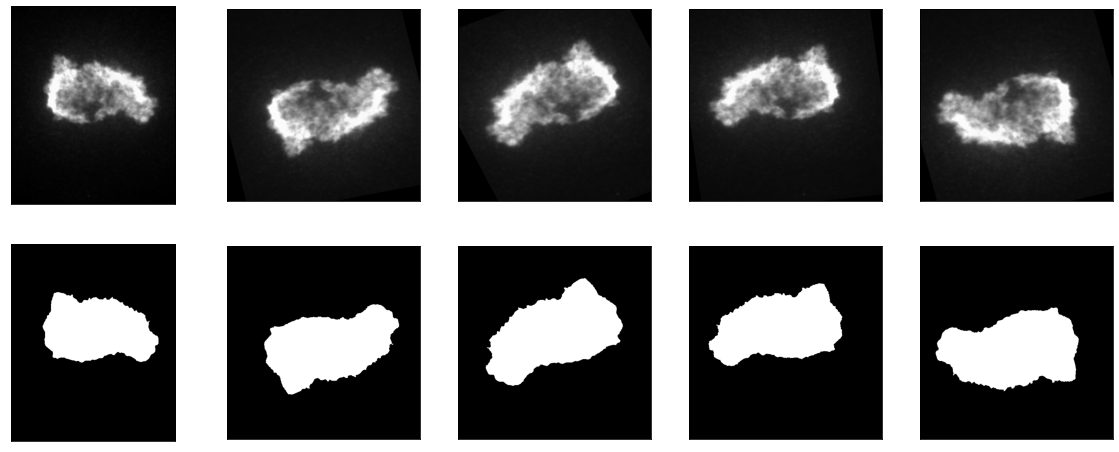

In [ ]:
plt.figure(figsize=(20,8))

idx = 20

plt.subplot(2,5,1)
plt.imshow(np.array(train_dataset.images[idx]), cmap='gray')
plt.xticks([]);
plt.yticks([]);

plt.subplot(2,5,6)
plt.imshow(np.array(train_dataset.labels[idx]), cmap='gray')
plt.xticks([]);
plt.yticks([]);

for k in range(1,5):
    xt, yt = train_dataset[idx]

    plt.subplot(2,5,k+1)
    plt.imshow(xt[0], cmap='gray')
    plt.xticks([]);
    plt.yticks([]);

    plt.subplot(2,5,5+k+1)
    plt.imshow(yt[0], cmap='gray')
    plt.xticks([]);
    plt.yticks([]);

plt.savefig('exemplo_augment.eps', format='eps')

In [ ]:
x_train, y_train = train_dataset[60]
x_val, y_val = val_dataset[10]
x_test, y_test = test_dataset[30]

print(x_train.shape, y_train.shape, len(train_dataset))
print(x_val.shape, y_val.shape, len(val_dataset))
print(x_test.shape, y_test.shape, len(test_dataset))

torch.Size([3, 512, 512]) torch.Size([1, 512, 512]) 234
torch.Size([3, 512, 512]) torch.Size([1, 512, 512]) 58
torch.Size([3, 512, 512]) torch.Size([1, 512, 512]) 96


## Instantiating the Dataloader

In [ ]:
batch_size = 6

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True)

val_dataloader = DataLoader(val_dataset,
                              batch_size = batch_size,
                              shuffle = False)

test_dataloader = DataLoader(test_dataset,
                              batch_size = batch_size,
                              shuffle = False)

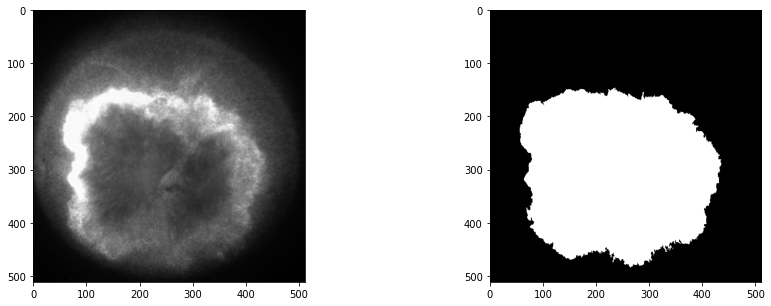

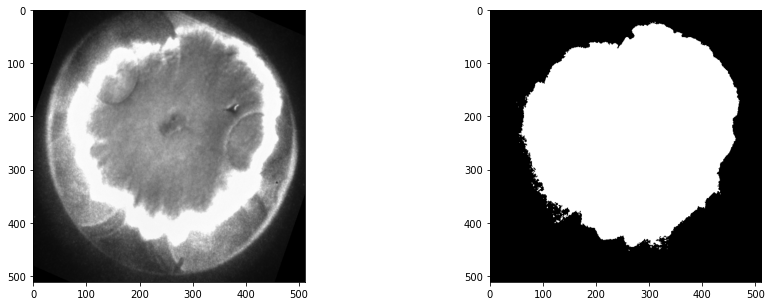

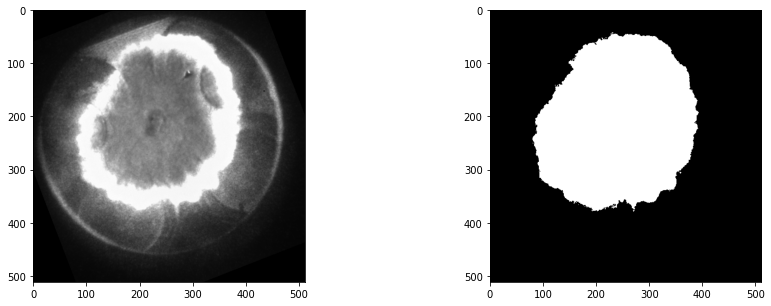

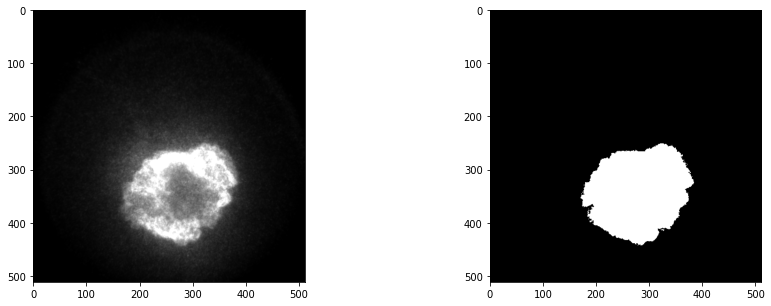

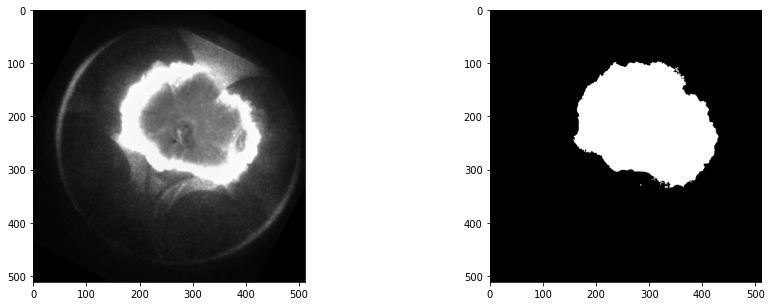

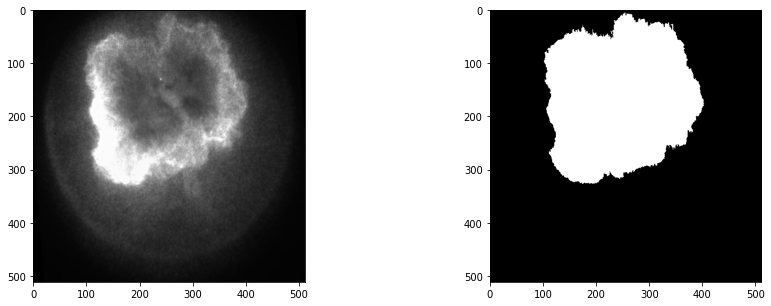

In [ ]:
xt, yt = next(iter(train_dataloader))

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(xt[k,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(yt[k,0], cmap='gray')

# Instantiating the model

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch',
                       'unet',
                       in_channels = 3,
                       out_channels = 2,
                       init_features = 64,
                       pretrained = False)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loss

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth = 1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_true, y_pred):
        # y_true: (batch_size, L, W)
        # y_pred: (batch_size, num_classes, L, W)

        num_classes = y_pred.shape[1]
        y_pred = torch.softmax(y_pred, dim=1) # probabilidades para cada classe

        # y_pred: (batch_size, 1, L, W)
        b_size = y_pred.shape[0] # determina o batch size

        # a loss é calculada e somada, para cada imagem do batch, separadamente
        loss = 0
        for c in range(num_classes):
            pred_c = y_pred[:,c,:,:].contiguous().view(b_size,-1) # probabilidades da classe c
            true_c = 1*(y_true == c).contiguous().view(b_size,-1) # =1 para valores da classe c
            inter = (pred_c * true_c).sum(axis=1)
            loss += (2 * inter + self.smooth) / (num_classes*(pred_c.sum(axis=1) + true_c.sum(axis=1) + self.smooth))
        
        #loss = 1/num_classes

        # loss: (batch_size, 1)
        return 1 - loss.unsqueeze(1)

# Lightning

In [ ]:
class LightningClassifier(LightningModule):
    def __init__(self, hparams, modelo):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.criterion = DiceLoss()
        self.model = modelo

        self.train_loss = []
        self.val_loss = []

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.model(x)

        batch_losses = self.criterion(y, logits)

        loss = batch_losses.mean(dim=0)
        # run['train/batch_loss'].log(loss)

        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'] for output in outputs]).mean()
        self.train_loss.append(avg_loss.item())
        #run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x)
        batch_losses = self.criterion(y, logits)
        
        return {'batch_losses': batch_losses}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'] for output in outputs]).mean()

        # run['valid/loss'].log(avg_loss)

        metrics = {'valid_loss': avg_loss.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}
        self.val_loss.append(avg_loss.item())
        
        self.log('valid_loss', avg_loss.item(), prog_bar=True)

        return output
  
    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x)
        batch_losses = self.criterion(y, logits)

        return {'batch_losses': batch_losses}

    def test_epoch_end(self, outputs):
        avg_loss = torch.vstack([output['batch_losses'] for output in outputs]).mean()

        # run['valid/loss'].log(avg_loss)
        metrics = {'Test loss': avg_loss.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss.item())

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr = self.hparams['learning_rate'])
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.99)
        return [optimizer], [scheduler]

In [ ]:
hparams = {
    'max_epochs': 50,
    'learning_rate': 1e-3
}

pl_model = LightningClassifier(hparams=hparams, modelo=model)

trainer = Trainer(max_epochs = hparams['max_epochs'], gpus=1)

trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | criterion | DiceLoss | 0     
1 | model     | UNet     | 31.0 M
---------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Global seed set to 123


Loss

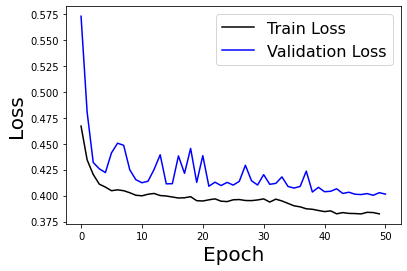

In [ ]:
plt.plot(pl_model.train_loss, color='k')
plt.plot(pl_model.val_loss, color='blue')

plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(['Train Loss', 'Validation Loss'], fontsize=16)

Avaliando a saída

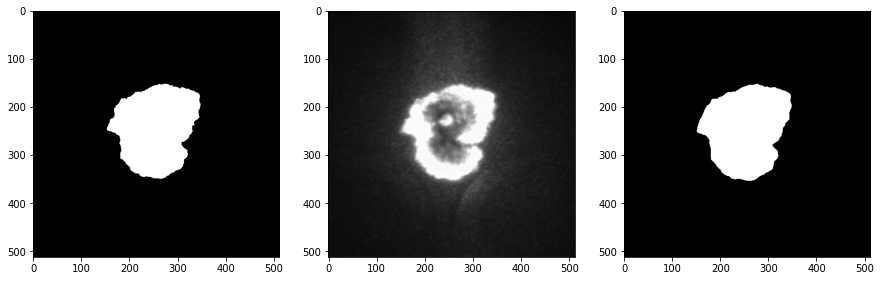

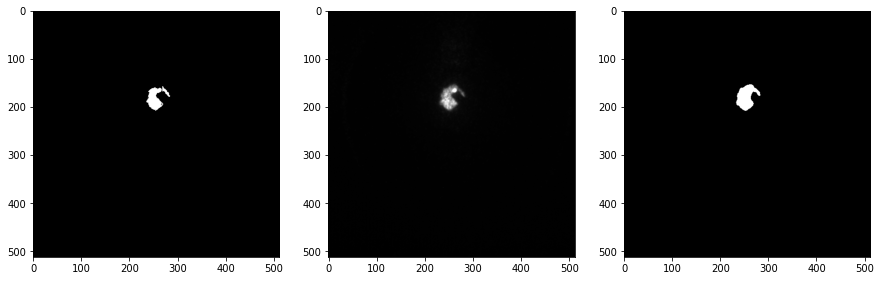

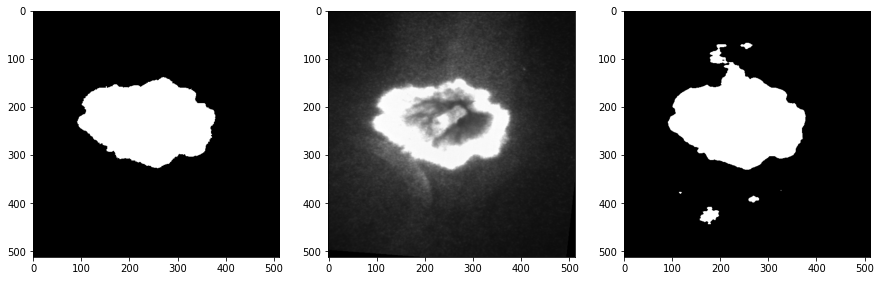

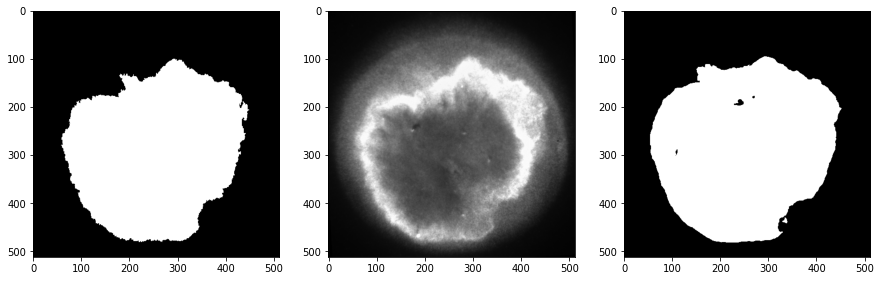

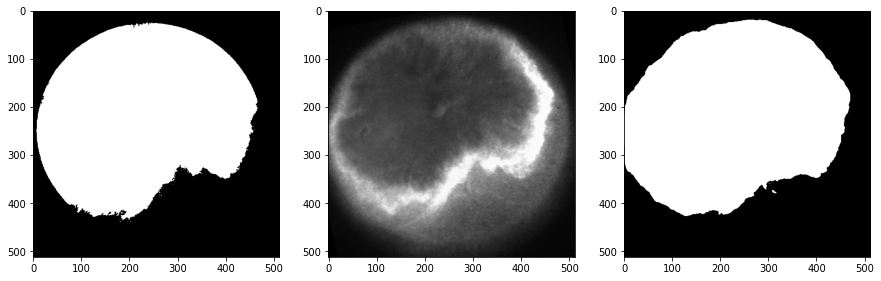

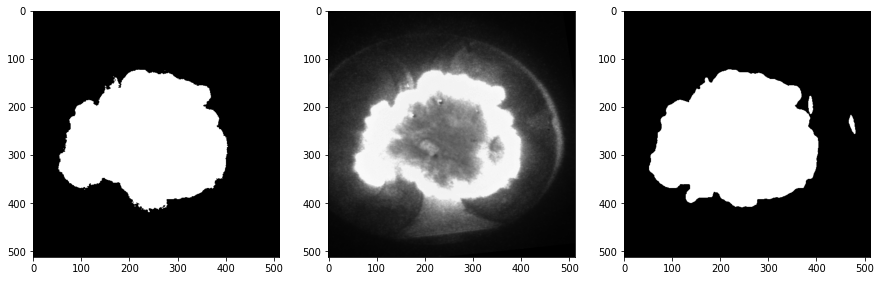

In [ ]:
x,y = next(iter(train_dataloader))

model.eval()
model.to('cuda')
with torch.no_grad():
    out = model.forward(x.to('cuda'))

outs = torch.argmax(out.to('cpu'), dim=1)

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(y[k,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(x[k,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.imshow(np.array(outs[k]), cmap='gray')

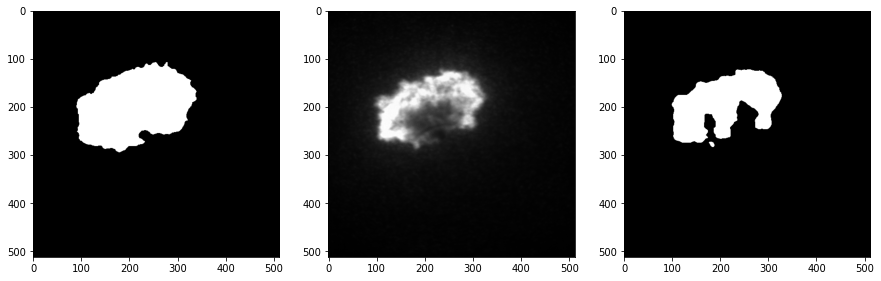

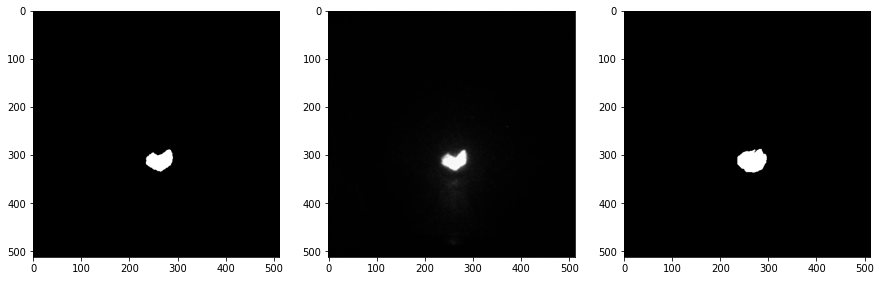

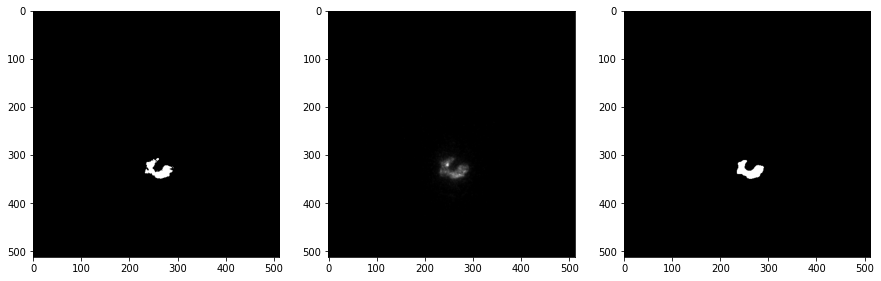

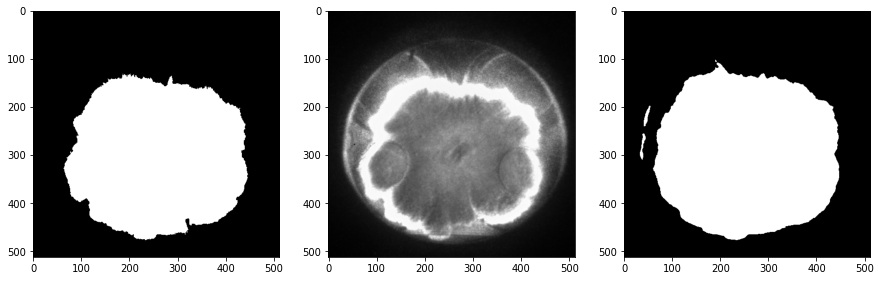

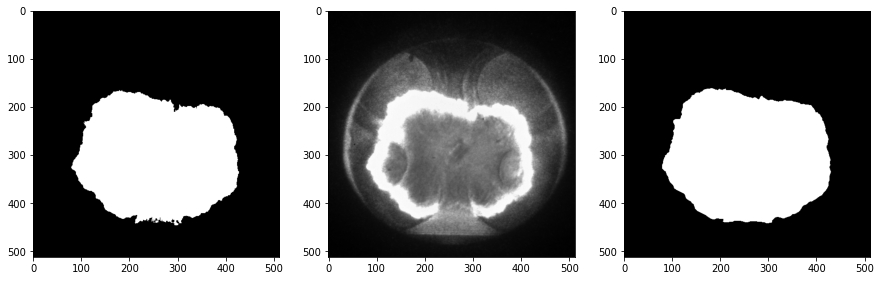

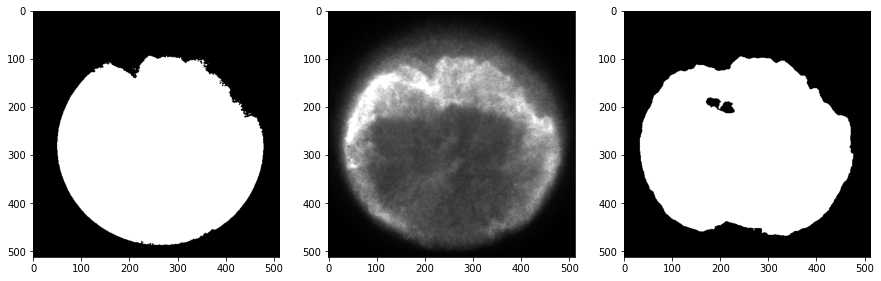

In [ ]:
x,y = next(iter(test_dataloader))

model.eval()
model.to('cuda')
with torch.no_grad():
    out = model.forward(x.to('cuda'))

outs = torch.argmax(out.to('cpu'), dim=1)

for k in range(batch_size):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(y[k,0], cmap='gray')

    plt.subplot(1,3,2)
    plt.imshow(x[k,0], cmap='gray')

    plt.subplot(1,3,3)
    plt.imshow(np.array(outs[k]), cmap='gray')

# Evaluating

Dice coefficient:

In [ ]:
def dice(x,y):
    eps = 1e-3;
    inter = (x*y).sum()
    return 2*inter/(x.sum() + y.sum() + eps)

Traditional method:

In [ ]:
def otsu(f):
     n = np.product(np.shape(f))
     h = 1.*np.bincount(f.ravel()) / n  
     if len(h) == 1: return 1,1
     x = np.arange(np.product(np.shape(h)))
     w0 = np.cumsum(h)
     w1 = 1 - w0
     eps = 1e-10
     m0 = np.cumsum(x * h) / (w0 + eps)
     mt = m0[-1]
     m1 = (mt - m0[0:-1]*w0[0:-1]) / w1[0:-1]
     sB2 = w0[0:-1] * w1[0:-1] * ((m0[0:-1] - m1)**2)
     t = np.argmax(sB2)
     v = sB2[t]
     st2 = sum((x-mt)**2 * h)
     eta = v / st2
     return t, eta

In [ ]:
def to_255(x):
    xmin,_ = x.min(axis=2, keepdims=True)
    xmin,_ = xmin.min(axis=3, keepdims=True)

    xmax,_ = x.max(axis=2, keepdims=True)
    xmax,_ = xmax.max(axis=3, keepdims=True)

    x = 255*(x-xmin)/(xmax-xmin)

    return x

In [ ]:
model.eval()

model.to('cuda')

img = []
gt = []
out_unet = []

for x,y in test_dataloader:
    x_dnorm = dnorm(x, train_mean.unsqueeze(1).unsqueeze(1), train_std.unsqueeze(1).unsqueeze(1))
    x_255 = to_255(x_dnorm)
    
    img.append(x_255)
    gt.append(y)
    with torch.no_grad():
        out = model.forward(x.to('cuda'))
        out_unet.append(out)

out_unet = torch.vstack(out_unet)
out_unet = torch.argmax(out_unet, dim=1)

img = torch.vstack(img)
gt = torch.vstack(gt)

Calculating traditional segmentation and Dice coefficients:

In [ ]:
out_otsu = []
dice_otsu = []
dice_unet = []

for k in range(len(img)):
    if k != 76:
        t,_ = otsu(img[k,0].to('cpu'))
        ots = img[k,0] > t
        out_otsu.append(ots*1.0)
        dice_otsu.append(dice(ots, gt[k]))
        dice_unet.append(dice(out_unet[k].to('cpu'), gt[k]))

out_otsu = torch.stack(out_otsu)
dice_otsu = np.array(dice_otsu)
dice_unet = np.array(dice_unet)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


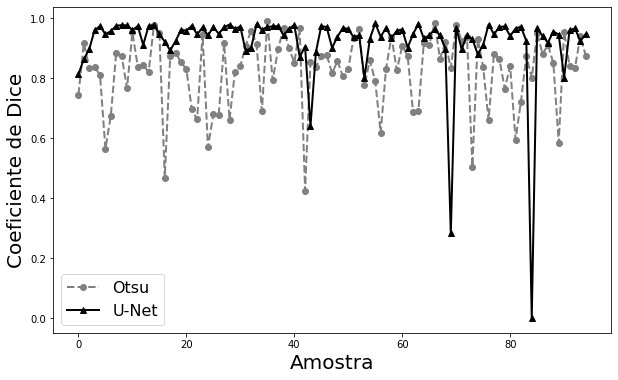

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(dice_otsu, color='gray', linestyle='--', marker='o', linewidth=2)
plt.plot(dice_unet, color='black', marker='^', linewidth=2)
plt.ylabel('Coeficiente de Dice', fontsize=20);
plt.xlabel('Amostra', fontsize=20);
plt.legend(['Otsu', 'U-Net'], fontsize=16);
plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/dice_{size[0]}x{size[1]}_unet.eps', format='eps')

In [ ]:
print(np.mean(dice_otsu))
print(np.mean(dice_unet))

0.82697254
0.92210984


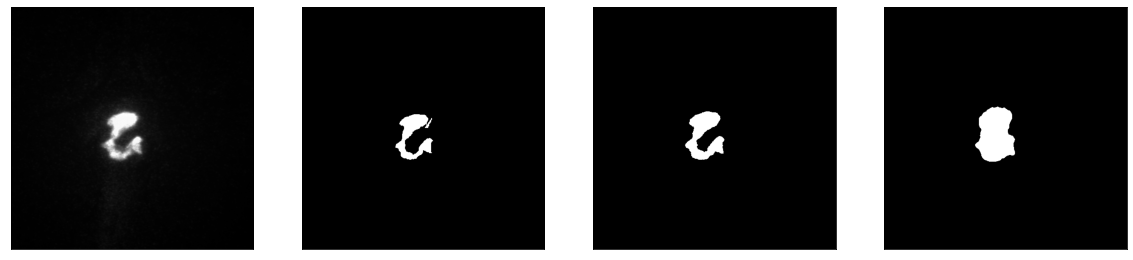

In [ ]:
idx = 43

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(img[idx,0], 'gray')
plt.yticks([]);
plt.xticks([]);

plt.subplot(1,4,2)
plt.imshow(gt[idx,0], 'gray')
plt.yticks([]);
plt.xticks([]);

plt.subplot(1,4,3)
plt.imshow(out_otsu[idx], 'gray')
plt.yticks([]);
plt.xticks([]);

plt.subplot(1,4,4)
plt.imshow(out_unet[idx].to('cpu'), 'gray')
plt.yticks([]);
plt.xticks([]);

# Inference time

In [ ]:
from timeit import default_timer as timer

In [ ]:
test_dataloader_inf = DataLoader(test_dataset,
                                batch_size = 1,
                                shuffle = False)

On GPU

In [ ]:
times = []
model.to('cuda')
with torch.no_grad():
    for xt,_ in test_dataloader_inf:
        xt = xt.to('cuda')
        
        start = timer()
        out = model(xt)
        end = timer()

        times.append(end-start)
print(np.mean(times))

0.0024932830625061797


On CPU

In [ ]:
times = []
model.to('cpu')
with torch.no_grad():
    for xt,_ in test_dataloader_inf:        
        start = timer()
        out = model(xt)
        end = timer()
        times.append(end-start)
print(np.mean(times))

5.362725429989591


# Image generation

In [ ]:
idxs = [12,17,21,50,58]

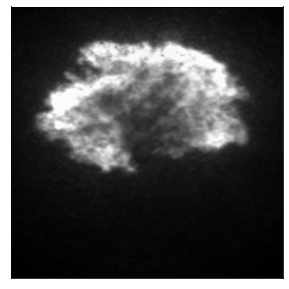

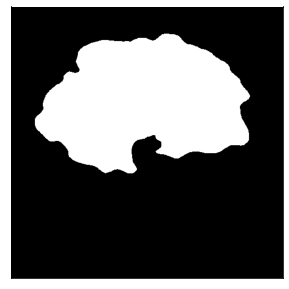

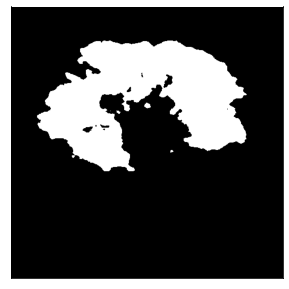

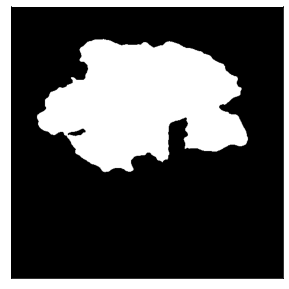

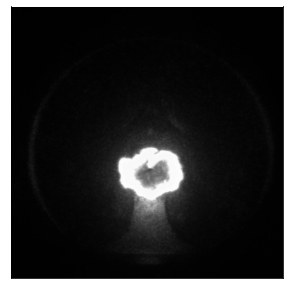

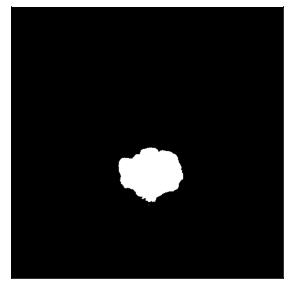

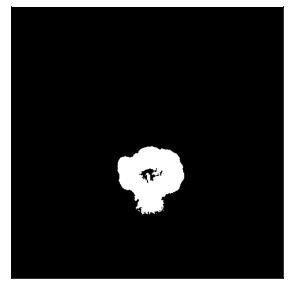

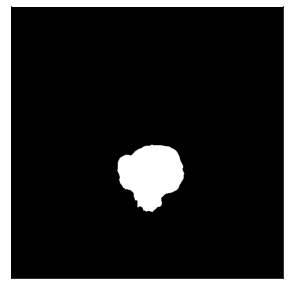

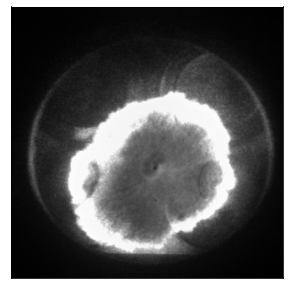

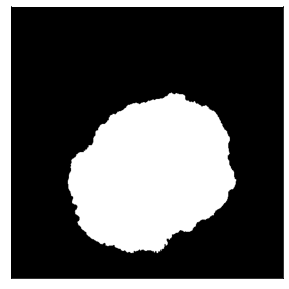

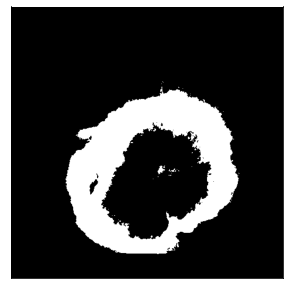

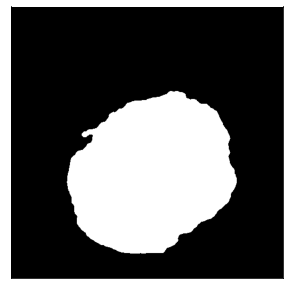

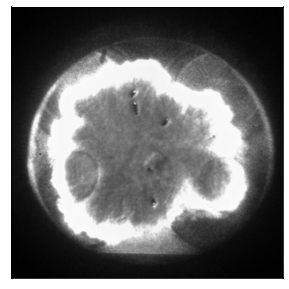

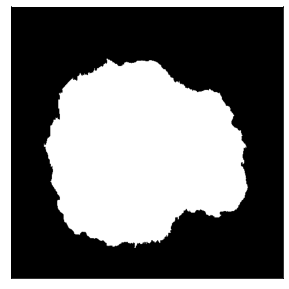

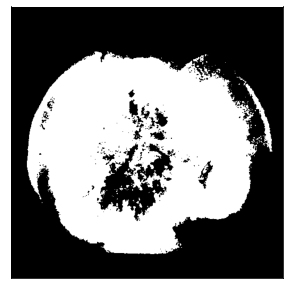

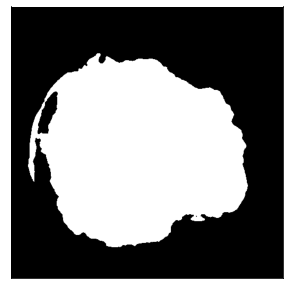

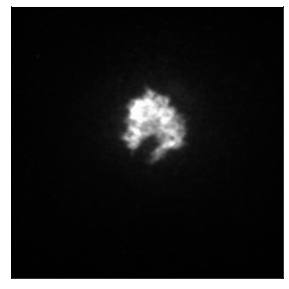

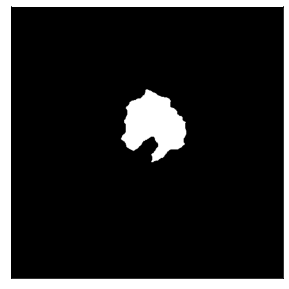

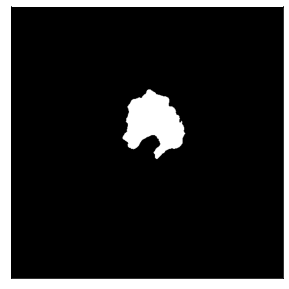

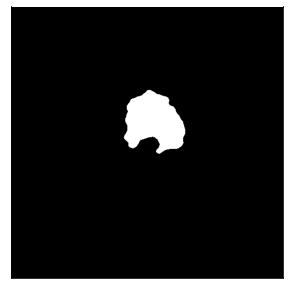

In [ ]:
for idx in idxs:
    plt.figure(figsize=(5,5))
    plt.imshow(img[idx,0], 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/original_{size[0]}x{size[1]}_{idx}.eps', format='eps')

    plt.figure(figsize=(5,5))
    plt.imshow(gt[idx,0], 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/gt_{size[0]}x{size[1]}_{idx}.eps', format='eps')

    plt.figure(figsize=(5,5))
    plt.imshow(out_otsu[idx], 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/otsu_{size[0]}x{size[1]}_{idx}.eps', format='eps')

    plt.figure(figsize=(5,5))
    plt.imshow(out_unet[idx].to('cpu'), 'gray')
    plt.yticks([]);
    plt.xticks([]);
    plt.savefig(f'/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Projeto Final/output_mixed/unet_{size[0]}x{size[1]}_{idx}.eps', format='eps')